In [1]:
import pandas as pd
from sentence_transformers import SentenceTransformer
import spacy
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

nlp = spacy.load("en_core_web_sm")

In [2]:
texts = pd.read_csv("../dat/generated_texts.csv")
texts.head()

,label,story,text
0,C2,"In less than a week, Turkey will hold its firs...","In less than a week, Turkey will hold its firs..."
1,C2,"When exploring New York City, there are severa...",In the heart of an urban jungle where concrete...
2,C2,No. 1 Florida State re-emerged in the second h...,"As the whistle blew, signaling the end of the ..."
3,C2,"Contemporary analytic philosophers, feminist a...",In the realm of contemporary analytic philosop...
4,C2,"﻿When Larry Pizzi, a veteran bicycle industry ...","When an industry veteran like Larry Pizzi, who..."


In [3]:
def get_sentences(text):
    doc = nlp(text)
    sentences = [token.text.strip() for token in doc.sents]
    return list(sentences)

texts = texts.dropna()
texts["sentences"] = texts.text.apply(get_sentences)

In [4]:
texts["sentences"][5]

['Amidst the vibrant tapestry of the bustling city, amidst the teeming crowds and the symphony of urban life, Dora embarked on a quest to find the perfect card for her mother.',
 "Next week marked her mother's birthday, a day that Dora eagerly awaited each year.",
 'The love she harbored for her mother was boundless, an unfathomable depth of affection that surpassed any words could adequately express.',
 'As Dora meandered through the crowded streets, her gaze flitted across the countless shops and boutiques that lined her path.',
 'However, none of the cards she encountered seemed to capture the profound sentiments she yearned to convey.',
 "Disappointment gnawed at her heart, and she began to lose hope of finding a card worthy of her mother's extraordinary spirit.",
 'In a stroke of serendipity, Dora stumbled upon a quaint little stationery shop nestled in a quiet corner of a side street.',
 'Intrigued, she stepped inside and was immediately captivated by the charming atmosphere that

In [5]:
texts = texts.explode("sentences")

In [6]:
len(texts)

5798

In [7]:
embeddings_model = SentenceTransformer('llmrails/ember-v1')
embeddings = embeddings_model.encode(list(texts["sentences"]))

In [8]:
embeddings.shape

(5798, 1024)

In [9]:
class FeedforwardNN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(FeedforwardNN, self).__init__()
        self.fc1 = torch.nn.Linear(input_dim, hidden_dim)
        self.relu = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(hidden_dim, 1)
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, x):
        hidden = self.relu(self.fc1(x))
        output = self.sigmoid(self.fc2(hidden))
        return output

In [10]:
egp = pd.read_csv('../dat/egponline.csv')

We now iterate over all models to get the classification scores.

In [11]:
for model_file in os.listdir("../models"):
    if not model_file.endswith(".pth"): continue
    nr = int(model_file[:-4])
    construction = egp[egp['#']==nr].iloc[0]
    print(str(construction['Can-do statement']))
    model = torch.load(f"../models/{model_file}")
    model.eval()
    model.to(device)
    outputs = model(torch.tensor(embeddings, device=device))
    sents = np.array(texts["sentences"])
    col_name = f"{construction['Level']}-{nr}"
    texts[col_name] = outputs.detach().cpu().squeeze()
    print(construction['Level'])
    print(texts.groupby("label")[col_name].mean())

Can use an increasing range of adverbs ('therefore', 'furthermore', 'otherwise') to show a relationship between two clauses or sentences. 
B1
label
A1    0.103845
A2    0.085303
B1    0.082358
B2    0.077129
C1    0.072036
C2    0.070058
Name: B1-100, dtype: float32
Can use an increasing range of phrasal verbs + object pronoun + particle. 
B1
label
A1    0.374535
A2    0.320923
B1    0.262655
B2    0.250490
C1    0.243019
C2    0.230730
Name: B1-1061, dtype: float32
Can use a wide range of phrasal verbs + object pronoun + particle. 
C1
label
A1    0.300359
A2    0.233919
B1    0.217476
B2    0.198467
C1    0.203626
C2    0.187141
Name: C1-1065, dtype: float32
Can use 'help' + object + infinitive with or without 'to', with no change in meaning. 
B1
label
A1    0.149024
A2    0.124548
B1    0.090039
B2    0.080531
C1    0.064074
C2    0.066462
Name: B1-1086, dtype: float32
Can use 'if' + present simple with present simple, 'can' or imperative in the main clause to refer to things that ar

In [12]:
texts.head()

,label,story,text,sentences,B1-100,B1-1061,C1-1065,B1-1086,A2-1107,A1-111,...,B1-69,A2-744,C2-782,A1-851,A1-852,B1-912,B2-932,A2-939,B1-950,A2-999
0,C2,"In less than a week, Turkey will hold its firs...","In less than a week, Turkey will hold its firs...","In less than a week, Turkey will hold its firs...",0.132540,0.007327,0.006026,0.001679,0.012521,0.258644,...,0.001399,0.001896,0.001276,0.009684,0.007514,0.010475,0.059811,0.091124,0.010103,0.002420
0,C2,"In less than a week, Turkey will hold its firs...","In less than a week, Turkey will hold its firs...",The nation finds itself at an unprecedented cr...,0.038962,0.105928,0.397699,0.006944,0.001213,0.000100,...,0.007987,0.015054,0.004690,0.004508,0.001081,0.016044,0.121283,0.051849,0.033695,0.001972
0,C2,"In less than a week, Turkey will hold its firs...","In less than a week, Turkey will hold its firs...",The country has long been plagued by political...,0.436008,0.068355,0.040543,0.059996,0.002286,0.011186,...,0.011110,0.009866,0.015081,0.003199,0.001283,0.017311,0.167265,0.320968,0.135240,0.003623
0,C2,"In less than a week, Turkey will hold its firs...","In less than a week, Turkey will hold its firs...",These struggles have eroded public trust in th...,0.126862,0.117568,0.083887,0.065751,0.003854,0.000635,...,0.015018,0.009981,0.001967,0.003164,0.001542,0.056085,0.198976,0.095417,0.044944,0.002219
0,C2,"In less than a week, Turkey will hold its firs...","In less than a week, Turkey will hold its firs...",The leading contenders in this election embody...,0.179611,0.046436,0.037598,0.010216,0.004116,0.000576,...,0.051709,0.055338,0.006174,0.016579,0.004685,0.017453,0.252750,0.407250,0.171552,0.003475


Let's check that against the ground truth source for the sentences.

In [13]:
levels = texts.label.unique()
for level in levels:
    #texts = texts.drop(level, axis=1)
    texts[level] = texts[[col for col in texts.columns if level in col]].mean(axis=1)
results = texts.groupby("label")[levels].mean()
results

,C2,C1,B2,B1,A2,A1
label,,,,,,
A1,0.113016,0.119153,0.063974,0.112229,0.092226,0.129861
A2,0.148803,0.141345,0.065468,0.100385,0.090551,0.079710
B1,0.176924,0.157541,0.066143,0.088300,0.086575,0.052990
B2,0.186107,0.166540,0.067340,0.086135,0.088355,0.047156
C1,0.201797,0.173383,0.068144,0.080810,0.081917,0.043425
C2,0.195861,0.172943,0.065516,0.080121,0.086300,0.045147


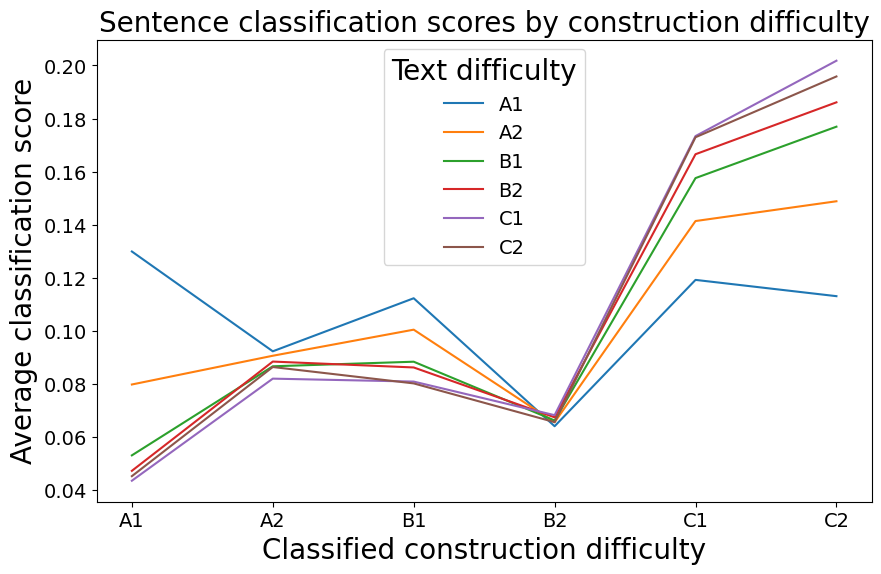

In [14]:
from matplotlib import rcParams

# Update default font sizes
rcParams.update({'font.size': 20, 'axes.labelsize': 20, 'axes.titlesize': 20, 'xtick.labelsize': 14,
                 'ytick.labelsize': 14, 'legend.fontsize': 14})

df_sorted = results.sort_index(axis=1)

# Plotting
plt.figure(figsize=(10, 6))
for label in df_sorted.index:
    plt.plot(df_sorted.columns, df_sorted.loc[label, :], label=label)
plt.xlabel('Classified construction difficulty')
plt.ylabel('Average classification score')
plt.title('Sentence classification scores by construction difficulty')
plt.legend(title="Text difficulty")
plt.savefig(f'../doc/generated_scores.pdf', transparent=True, bbox_inches='tight')